In [94]:
import numpy as np
from math import pi
from matplotlib import pyplot
from scipy.linalg import block_diag
from scipy.optimize import minimize
import time
from ipywidgets import interact

In [300]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3
m0=9.1e-31 # kg
m=m0/10

B=10 # Tesla
hwc=hbar*(elec*B/m)
lB=np.sqrt(hbar/(elec*B))
mu_sc=20*hwc #1e2*meV
D_sc=2*hwc #10*meV
nu=1
mu_n=nu*hwc #10*meV

# ky_sw=np.linspace(0.4,0.8,200)*1.5/lB
Lx=8*lB
# Nx=200

def system_E_vs_k(k0,Nx=100,U0=0,Ls=Lx):
    ky_sw=k0/lB
    kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
    [k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)

    Hx=np.diag(hbar**2 * kx**2/(2*m))

    def y2(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
            c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
        return c

    def y1(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
            c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
        return c

    def y0(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
        return c

    def y0s(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
        return c

    HeB2= ((elec*B)**2 * np.real(y2(k1-k2)) )/ m
    HeB2T= ((elec*B)**2 * np.real(y2(k2-k1)) )/ m
    Hef= -( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2)+U0*np.ones(k1.shape) )
    HefT=-( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1)+U0*np.ones(k1.shape) )
    Hd= D_sc*y0s(k1-k2) 

    En=np.zeros(ky_sw.shape)
    for i_k in range(len(ky_sw)):
        ky=ky_sw[i_k]
        Hy=(hbar**2 * ky**2/(2*m))*np.eye(Nx)
        HeB1=-2j*hbar *ky* ( elec*B*np.imag(y1(k1-k2)))/m
        HeB1T=2j*hbar *ky* ( elec*B*np.imag(y1(k2-k1)))/m
        H1=Hx+Hy+HeB2+HeB1+Hef
        H1T=Hx+Hy+(HeB2T+HeB1T+HefT).conj()
        Hd_mat=np.kron(np.array([[0.,1.0],[0.,0.]]),Hd)
        H_t=block_diag(H1,-H1T)+Hd_mat+np.transpose(Hd_mat).conj()
        Evals, _ =np.linalg.eigh(H_t)
        En[i_k]=Evals[Nx]/hwc
    return En


def system_builder(k0,Nx=100,U0=0,Ls=Lx):
    ky=k0/lB
    kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
    [k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)

    Hx=np.diag(hbar**2 * kx**2/(2*m))

    def y2(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
            c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
        return c

    def y1(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
            c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
        return c

    def y0(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
        return c

    def y0s(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
#             d=1.0+1e-3 # add imabalance to break LR symmetry
#             c = (d*np.exp(1j*k*Ls/2)-np.exp(-1j*k*Ls/2))/(1j*k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
        return c

    HeB2= ((elec*B)**2 * np.real(y2(k1-k2)) )/ m
    HeB2T= ((elec*B)**2 * np.real(y2(k2-k1)) )/ m
    Hef= -( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2)+U0*np.ones(k1.shape) )
    HefT=-( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1)+U0*np.ones(k1.shape) )
#     d=1.0+1e-1 # add imabalance to break LR symmetry
#     Hef= -( mu_n*(y0(k1-k2)+d*y0(k2-k1)) + mu_sc*y0s(k1-k2)+U0*np.ones(k1.shape) )
#     HefT=-( mu_n*(y0(k1-k2)+d*y0(k2-k1)) + mu_sc*y0s(k2-k1)+U0*np.ones(k1.shape) )
    Hd= D_sc*y0s(k1-k2) 

    Hy=(hbar**2 * ky**2/(2*m))*np.eye(Nx)
    HeB1=-2j*hbar *ky* ( elec*B*np.imag(y1(k1-k2)))/m
    HeB1T=2j*hbar *ky* ( elec*B*np.imag(y1(k2-k1)))/m
    H1=Hx+Hy+HeB2+HeB1+Hef
    H1T=Hx+Hy+(HeB2T+HeB1T+HefT).conj()
    Hd_mat=np.kron(np.array([[0.,1.0],[0.,0.]]),Hd)
    H_t=block_diag(H1,-H1T)+Hd_mat+np.transpose(Hd_mat).conj()
    En, Vs =np.linalg.eigh(H_t)

    return kx,En[[Nx-1,Nx]],Vs[:,[Nx-1,Nx]]

def wf_real_space(ev,k,x,Ls):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    return np.dot(np.exp(1j*kt*(xt-Ls/2)),ev[:Nx,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
            np.dot(np.exp(1j*kt*(xt+Ls/2)),ev[Nx:2*Nx,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])

In [54]:
U1=0*hwc
Ls1=6*lB

fmin=minimize(system_E_vs_k,x0=0.8,args=(U1,Ls1))
print(fmin.x[0])
print(fmin)

0.5369690206273211
      fun: 0.032029162624465646
 hess_inv: array([[0.06541653]])
      jac: array([6.5099448e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.53696902])


In [34]:
def fn(y,a=0,b=2):
    return y**3+b*y**2-a*y

a=2.25
b=2
fmin=minimize(fn,x0=0.3,args=(a,b))
print(fmin.x[0])

0.4262397450951981


[[-0.04578663-0.00606034j  0.00672783-0.03297574j]
 [ 0.03237809+0.00918271j  0.01566418-0.04344856j]]


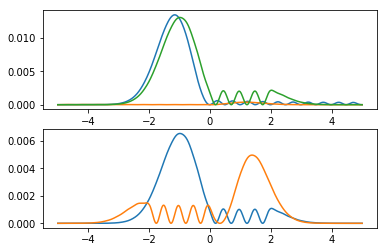

In [242]:
U1=10*hwc
U2=0*hwc
Ls1=10.*lB
Ls2=2.*lB
x0=np.linspace(-1,1,500)*5*lB
f1=minimize(system_E_vs_k,x0=0.8,args=(U1,Ls1))
kx1,Eb,Vb= system_builder(1.01*f1.x[0],U0=U1,Ls=Ls1)
f2=minimize(system_E_vs_k,x0=0.8,args=(U2,Ls2))    
kx2,Em,Vm= system_builder(f2.x[0],U0=U2,Ls=Ls2)

Emat=np.diag(Em)
VmVb=np.dot(np.transpose(Vm).conj(),Vb)
Hmat=np.dot(np.transpose(VmVb).conj(),np.dot(Emat,VmVb))
# print(Hmat/hwc)
# Hmat_diag=Hmat[0,0]/hwc
# Hmat_off=Hmat[0,1]/hwc
print(VmVb)

iwf=0
wf1_p,wf1_h=wf_real_space(Vb,kx1,x0,Ls1)
wf2_p,wf2_h=wf_real_space(Vm,kx2,x0,Ls2)
pyplot.figure()
# pyplot.plot(x0/lB,np.imag(wf1_p[:,iwf]))
# pyplot.plot(x0/lB,np.real(wf1_p[:,iwf]))
pyplot.subplot(2,1,1)
pyplot.plot(x0/lB,np.abs(wf1_p[:,iwf])**2)
pyplot.plot(x0/lB,np.abs(wf1_h[:,iwf])**2)
pyplot.plot(x0/lB,2*np.abs(wf2_p[:,iwf])**2)
pyplot.subplot(2,1,2)
pyplot.plot(x0/lB,np.abs(wf2_p[:,iwf])**2)
pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf])**2)
# pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf]))
pyplot.show()

Dependence of Delta/Gamma on SC width

In [260]:
# def wf_real_space(ev,k,x,Ls):
#     kt=np.reshape(k,[1,Nx])
#     xt=np.reshape(x,[len(x),1])
#     return np.dot(np.exp(1j*kt*xt),ev[:Nx,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
#             np.dot(np.exp(1j*kt*xt),ev[Nx:2*Nx,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])

t_timer=time.time()

Ls_sw=np.linspace(20,60,80)*lB
# Ls_sw=np.arange(2,11)*lB
# Ls_sw=np.array([2])*lB
x0=np.linspace(-1,1,500)*10*lB
ky_sw=np.linspace(0.5,0.6,40)
wf1_p=np.zeros((len(x0),2,len(Ls_sw)), dtype=np.complex64)
wf1_h=np.zeros((len(x0),2,len(Ls_sw)), dtype=np.complex64)
wf2_p=np.zeros((len(x0),2,len(Ls_sw)), dtype=np.complex64)
wf2_h=np.zeros((len(x0),2,len(Ls_sw)), dtype=np.complex64)
Hmat_diag= np.zeros(len(Ls_sw), dtype=np.complex64)
Hmat_off= np.zeros(len(Ls_sw), dtype=np.complex64)
Ek1= np.zeros((len(ky_sw),len(Ls_sw)))
Ek2= np.zeros((len(ky_sw),len(Ls_sw)))
Eb_mat= np.zeros((2,len(Ls_sw)))
Eg_mat= np.zeros((2,len(Ls_sw)))
kpt=np.zeros((2,len(Ls_sw)))
for i_L in range(len(Ls_sw)):
    print(i_L, end='\r')
    Ls=Ls_sw[i_L]
    U1=100*hwc
    U2=0*hwc
    f1=minimize(system_E_vs_k,x0=0.8,args=(U1,Ls))
    kx1,Eb,Vb= system_builder(1.1*f1.x[0],U0=U1,Ls=Ls)
    f2=minimize(system_E_vs_k,x0=0.8,args=(U2,Ls))    
    kx2,Em,Vm= system_builder(f2.x[0],U0=U2,Ls=Ls)
    kpt[:,i_L]=np.array([f1.x[0],f2.x[0]])
    
    wf1_p[:,:,i_L],wf1_h[:,:,i_L]=wf_real_space(Vb,kx1,x0,Ls)
    wf2_p[:,:,i_L],wf2_h[:,:,i_L]=wf_real_space(Vm,kx2,x0,Ls)

#     Ek1[:,i_L]=system_E_vs_k(ky_sw,U0=U1,Ls=Ls)
#     Ek2[:,i_L]=system_E_vs_k(ky_sw,U0=U2,Ls=Ls)

    Emat=np.diag(Em)
    VmVb=np.dot(np.transpose(Vm).conj(),Vb)
    Hmat=np.dot(np.transpose(VmVb).conj(),np.dot(Emat,VmVb))
#     print(Hmat/hwc)
    Hmat_diag[i_L]=Hmat[0,0]/hwc
    Hmat_off[i_L]=Hmat[0,1]/hwc
    Eb_mat[:,i_L]=Eb
    Eg_mat[:,i_L]=Em

    
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")

Finished, elapsed time = 283 sec


In [261]:
def plot_wf(i_L):
#     pyplot.figure()
# #     pyplot.subplot(3,1,1)
#     pyplot.plot(ky_sw,Ek1[:,i_L],'b')
#     pyplot.plot(kpt[0,i_L],Eb_mat[1,i_L]/hwc,'bo')
#     pyplot.plot(ky_sw,Ek2[:,i_L],'r')
#     pyplot.plot(kpt[1,i_L],Eg_mat[1,i_L]/hwc,'ro')
#     pyplot.title('L=%d' % (Ls_sw[i_L]/lB) )
#     pyplot.ylabel("Energy(meV)")
#     pyplot.xlabel("X(l)")
#     pyplot.show()

    iwf=0
    pyplot.figure()
    pyplot.subplot(2,1,1)
    pyplot.plot(x0/lB,np.abs(wf1_p[:,iwf,i_L])**2)
    pyplot.plot(x0/lB,np.abs(wf1_h[::-1,iwf,i_L])**2)
#     pyplot.plot([-Ls_sw[i_L],-Ls_w[i_L]]/(2*lB),[0.0,0.03],'k--')
#     pyplot.plot(x0/lB,2*np.abs(wf2_p[:,iwf,i_L])**2)
    pyplot.title('L=%.2f' % (Ls_sw[i_L]/lB) )
    pyplot.subplot(2,1,2)
#     pyplot.plot([-Ls_sw[i_L],-Ls_sw[i_L]]/(2*lB),[0.0,0.015],'k--')
#     pyplot.plot([Ls_sw[i_L],Ls_sw[i_L]]/(2*lB),[0.0,0.015],'k--')
    pyplot.plot(x0/lB,np.abs(wf2_p[:,iwf,i_L])**2)
    pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf,i_L])**2)
    pyplot.show()
    
interact(plot_wf, i_L=(0,len(Ls_sw)-1,1));

interactive(children=(IntSlider(value=39, description='i_L', max=79), Output()), _dom_classes=('widget-interac…

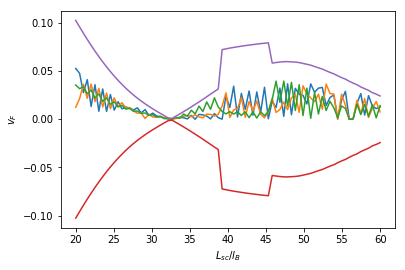

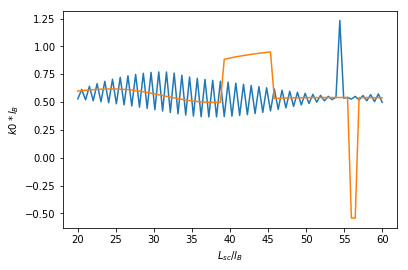

In [262]:
pyplot.figure()
# pyplot.plot(Ls_sw/lB,np.abs(np.imag(Hmat_off)/Hmat_diag))
pyplot.plot(Ls_sw/lB,np.abs(np.real(Hmat_off)))
pyplot.plot(Ls_sw/lB,np.abs(np.imag(Hmat_off)))
# pyplot.plot(Ls_sw/lB,np.abs(Hmat_off))
pyplot.plot(Ls_sw/lB,np.abs(Hmat_diag))
# pyplot.plot(Ls_sw/lB,Eb_mat.T/hwc)
pyplot.plot(Ls_sw/lB,Eg_mat.T/hwc)
# pyplot.plot(Ls_sw/lB,np.abs(np.imag(Hmat_off)/np.real(Hmat_off)))
pyplot.xlabel(r"$L_{sc}/l_B$")
pyplot.ylabel(r"$v_F$")
# pyplot.ylim(0,1)
pyplot.show()

pyplot.figure()
pyplot.plot(Ls_sw/lB,kpt[0,:])
pyplot.plot(Ls_sw/lB,kpt[1,:])
pyplot.xlabel(r"$L_{sc}/l_B$")
pyplot.ylabel(r"$k0*l_B$")
pyplot.show()


Comparison with Andreev Edge state

In [301]:
t_timer=time.time()

x0=np.linspace(-1,1,1000)*5*lB

U1=10*hwc
Ls1=20*lB
Nx1=200
f1=minimize(system_E_vs_k,x0=0.8,args=(Nx1,U1,Ls1))
kx1,Eb,Vb= system_builder(1.1*f1.x[0],Nx=Nx1,U0=U1,Ls=Ls1)
wf1_p,wf1_h=wf_real_space(Vb,kx1,x0,Ls1)
wf1_p=wf1_p[:,0]/np.linalg.norm(wf1_p[:,0])
wf1_h=wf1_h[:,1]/np.linalg.norm(wf1_h[:,1])

Ls_sw=np.linspace(2,10,80)*lB
# Ls_sw=np.arange(2,11)*lB
# Ls_sw=np.array([2])*lB
Nx2=100

wf2_p=np.zeros((len(x0),2,len(Ls_sw)), dtype=np.complex64)
wf2_h=np.zeros((len(x0),2,len(Ls_sw)), dtype=np.complex64)
Hmat_diag= np.zeros(len(Ls_sw), dtype=np.complex64)
Hmat_off= np.zeros(len(Ls_sw), dtype=np.complex64)
Eg_mat= np.zeros((2,len(Ls_sw)))
Vp= np.zeros((2,len(Ls_sw)), dtype=np.complex64)
Vh= np.zeros((2,len(Ls_sw)), dtype=np.complex64)
kpt=np.zeros(len(Ls_sw))
for i_L in range(len(Ls_sw)):
    print(i_L, end='\r')
    Ls=Ls_sw[i_L]
    U2=0*hwc
    f2=minimize(system_E_vs_k,x0=0.8,args=(Nx2,U2,Ls))    
    kx2,Em,Vm= system_builder(f2.x[0],Nx=Nx2,U0=U2,Ls=Ls)
    kpt[i_L]=f2.x[0]
    
    wf2_p[:,:,i_L],wf2_h[:,:,i_L]=wf_real_space(Vm,kx2,x0,Ls)

#     Emat=np.diag(Em)
    Vp[:,i_L]=np.dot(np.transpose(wf2_p[:,:,i_L]).conj(),wf1_p)
    Vh[:,i_L]=np.dot(np.transpose(wf2_h[:,:,i_L]).conj(),wf1_h)

#     Hmat=np.dot(np.transpose(VmVb).conj(),np.dot(Emat,VmVb))
# #     print(Hmat/hwc)
#     Hmat_diag[i_L]=Hmat[0,0]/hwc
#     Hmat_off[i_L]=Hmat[0,1]/hwc
#     Eb_mat[:,i_L]=Eb
    Eg_mat[:,i_L]=Em

    
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")

Finished, elapsed time = 42 sec


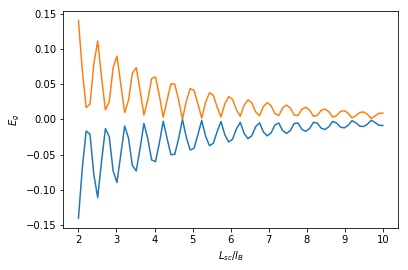

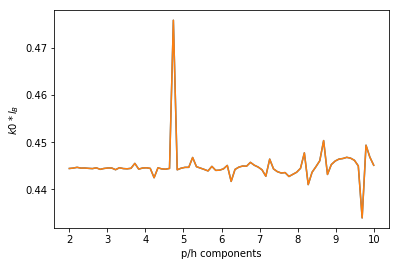

In [308]:
pyplot.figure()
pyplot.plot(Ls_sw/lB,Eg_mat.T/hwc)
pyplot.xlabel(r"$L_{sc}/l_B$")
pyplot.ylabel(r"$E_g$")
pyplot.show()

ratio=np.tan(abs(np.angle(Vp/Vh).T))**2
pyplot.figure()
pyplot.plot(Ls_sw/lB,np.mod(np.angle(Vp/Vh).T/pi,1))
# pyplot.plot(Ls_sw/lB,np.angle(Vp/Vh).T/pi)
# pyplot.plot(Ls_sw/lB,ratio/(1+ratio))
# pyplot.plot(Ls_sw/lB,Vh)
pyplot.xlabel("p/h components")
pyplot.ylabel(r"$k0*l_B$")
pyplot.show()

In [317]:
# f1=minimize(system_E_vs_k,x0=0.8,args=(Nx1,U1,Ls1))
# kx1,Eb,Vb= system_builder(1.1*f1.x[0],Nx=Nx1,U0=U1,Ls=Ls1)
# wf1_p,wf1_h=wf_real_space(Vb,kx1,x0,Ls1)

def plot_wf(i_L):
    iwf=1
    pyplot.figure()
    pyplot.plot(x0/lB,np.abs(wf1_p)**2/2)
    pyplot.plot(x0/lB,np.abs(wf2_p[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
    pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.real(wf1_p))
#     pyplot.plot(x0/lB,np.real(wf2_p[:,iwf,i_L]))
# #     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.imag(wf2_p[:,iwf,i_L]))
    pyplot.title('L=%.2f' % (Ls_sw[i_L]/lB) )
    pyplot.ylim([0,0.004])
    pyplot.show()
    
interact(plot_wf, i_L=(0,len(Ls_sw)-1,1));

interactive(children=(IntSlider(value=39, description='i_L', max=79), Output()), _dom_classes=('widget-interac…

In [309]:
np.tan(0.445*pi)

5.729741646724316